# Goal
The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the ```flow_from_dataframe``` to deal with messier datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('../input/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
104197,00027833_011.png,Pneumothorax,11,27833,50,M,AP,3056,2544,0.139,0.139,NaN,../input/images_011/images/00027833_011.png
8850,00002337_011.png,No Finding,11,2337,59,M,PA,2946,2937,0.143,0.143,NaN,../input/images_002/images/00002337_011.png
80020,00019651_000.png,Mass,0,19651,25,F,PA,2500,2048,0.168,0.168,NaN,../input/images_009/images/00019651_000.png


# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

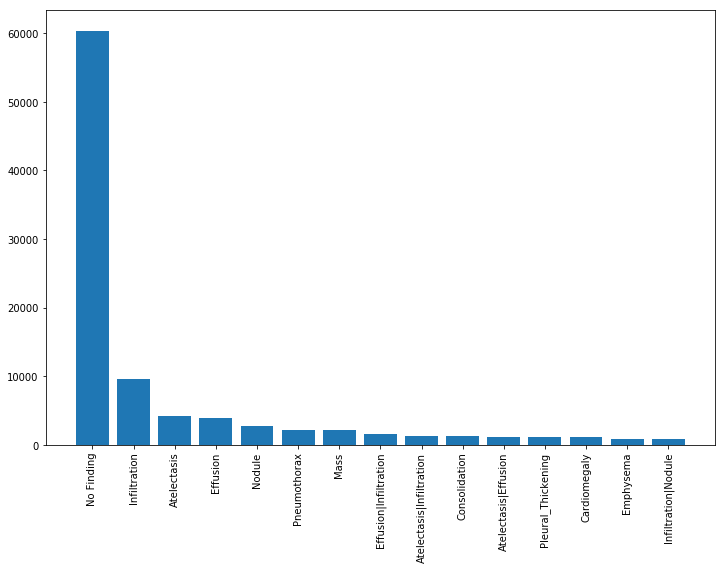

In [3]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12001,00003128_000.png,,0,3128,16,M,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82578,00020312_030.png,,30,20312,38,F,PA,2546,2653,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89272,00022156_009.png,Infiltration,9,22156,65,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [5]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


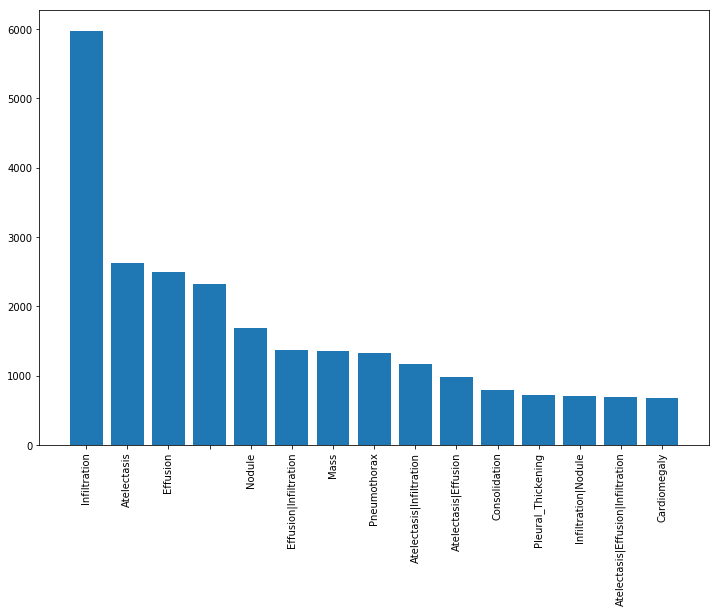

In [6]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

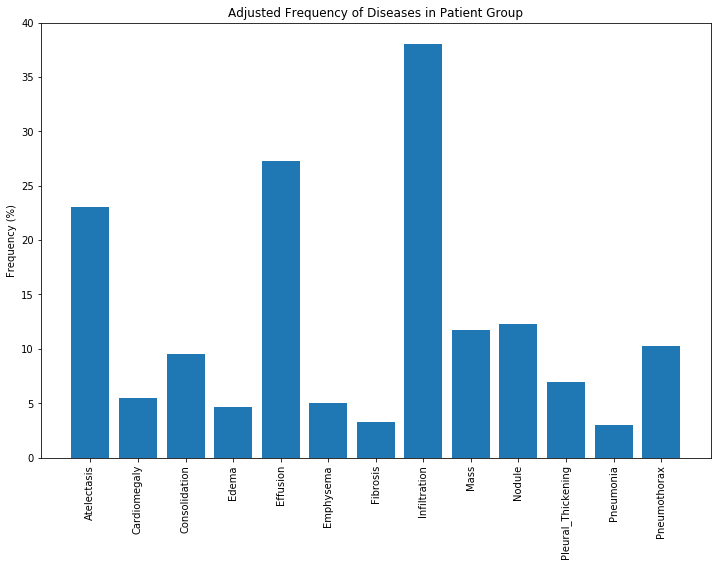

In [7]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [8]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [9]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [10]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [12]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 30000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images


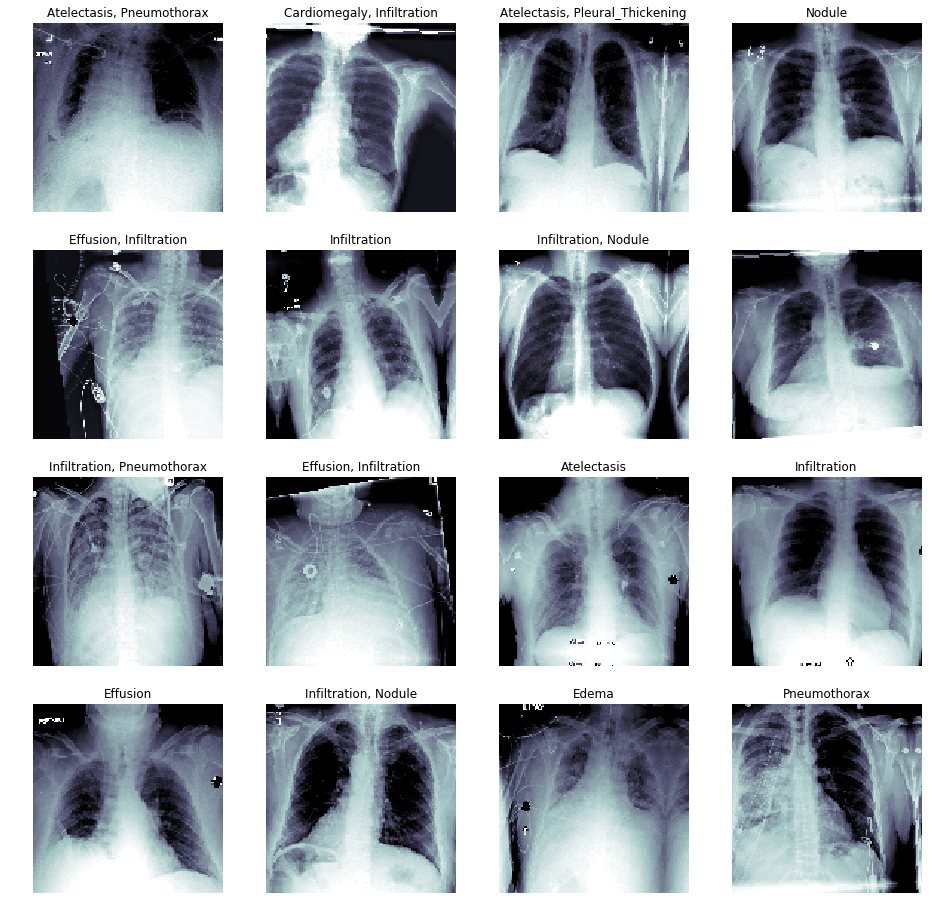

In [13]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [14]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

# First Round
Here we do a first round of training to get a few initial low hanging fruit results

In [16]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
 99/100 [============================>.] - ETA: 5s - loss: 0.4743 - binary_accuracy: 0.8503 - mean_absolute_error: 0.2034 
Epoch 00001: val_loss improved from inf to 1.40671, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 558s 6s/step - loss: 0.4737 - binary_accuracy: 0.8503 - mean_absolute_error: 0.2036 - val_loss: 1.4067 - val_binary_accuracy: 0.8223 - val_mean_absolute_error: 0.1735


# Check Output
Here we see how many positive examples we have of each category

In [17]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 25.20%
Cardiomegaly: 4.69%
Consolidation: 9.28%
Edema: 5.57%
Effusion: 27.83%
Emphysema: 5.86%
Fibrosis: 3.22%
Infiltration: 39.55%
Mass: 12.70%
Nodule: 12.30%
Pleural_Thickening: 6.45%
Pneumonia: 2.93%
Pneumothorax: 10.45%


In [18]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 44s 43ms/step


# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

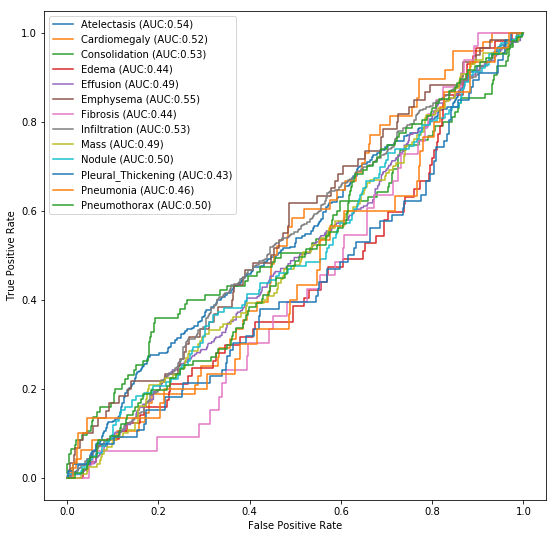

In [19]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

# Continued Training
Now we do a much longer training process to see how the results improve

In [20]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 7, 
                                  callbacks = callbacks_list)

Epoch 1/7
 99/100 [============================>.] - ETA: 5s - loss: 0.3941 - binary_accuracy: 0.8650 - mean_absolute_error: 0.2009 
Epoch 00001: val_loss improved from 1.40671 to 0.36704, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 543s 5s/step - loss: 0.3936 - binary_accuracy: 0.8651 - mean_absolute_error: 0.2008 - val_loss: 0.3670 - val_binary_accuracy: 0.8613 - val_mean_absolute_error: 0.2009
Epoch 2/7
 99/100 [============================>.] - ETA: 4s - loss: 0.3539 - binary_accuracy: 0.8699 - mean_absolute_error: 0.1955
Epoch 00002: val_loss improved from 0.36704 to 0.35851, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 540s 5s/step - loss: 0.3540 - binary_accuracy: 0.8700 - mean_absolute_error: 0.1955 - val_loss: 0.3585 - val_binary_accuracy: 0.8690 - val_mean_absolute_error: 0.1922
Epoch 3/7
 99/100 [============================>.] - ETA: 5s - loss: 0.3394 - binary_accuracy: 0.8743 - mean_abso

In [21]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [22]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 41s 40ms/step


In [23]:
print(pred_Y)

[[0.09862433 0.062456   0.11326391 ... 0.07977024 0.05686696 0.15895359]
 [0.10452846 0.04511942 0.09785288 ... 0.06664876 0.05358536 0.11218683]
 [0.17280462 0.03967695 0.0538345  ... 0.0735573  0.01937291 0.09619605]
 ...
 [0.07980259 0.0519238  0.10265287 ... 0.06592652 0.06665914 0.10149172]
 [0.1385985  0.04563188 0.19120567 ... 0.04845048 0.02890771 0.02582094]
 [0.10749209 0.03057982 0.03326866 ... 0.07266617 0.01655443 0.13248175]]


In [24]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 25.20%, PDx: 12.47%
Cardiomegaly: Dx: 4.69%, PDx: 4.81%
Consolidation: Dx: 9.28%, PDx: 9.84%
Edema: Dx: 5.57%, PDx: 7.23%
Effusion: Dx: 27.83%, PDx: 24.83%
Emphysema: Dx: 5.86%, PDx: 4.89%
Fibrosis: Dx: 3.22%, PDx: 2.72%
Infiltration: Dx: 39.55%, PDx: 49.59%
Mass: Dx: 12.70%, PDx: 12.68%
Nodule: Dx: 12.30%, PDx: 13.71%
Pleural_Thickening: Dx: 6.45%, PDx: 7.04%
Pneumonia: Dx: 2.93%, PDx: 4.16%
Pneumothorax: Dx: 10.45%, PDx: 9.61%


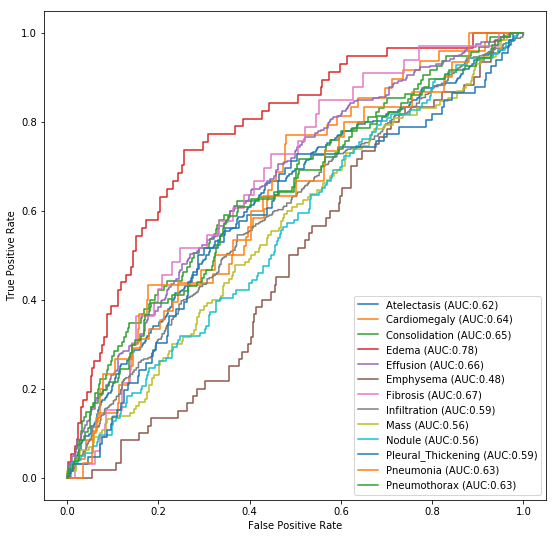

In [25]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

# Show a few images and associated predictions

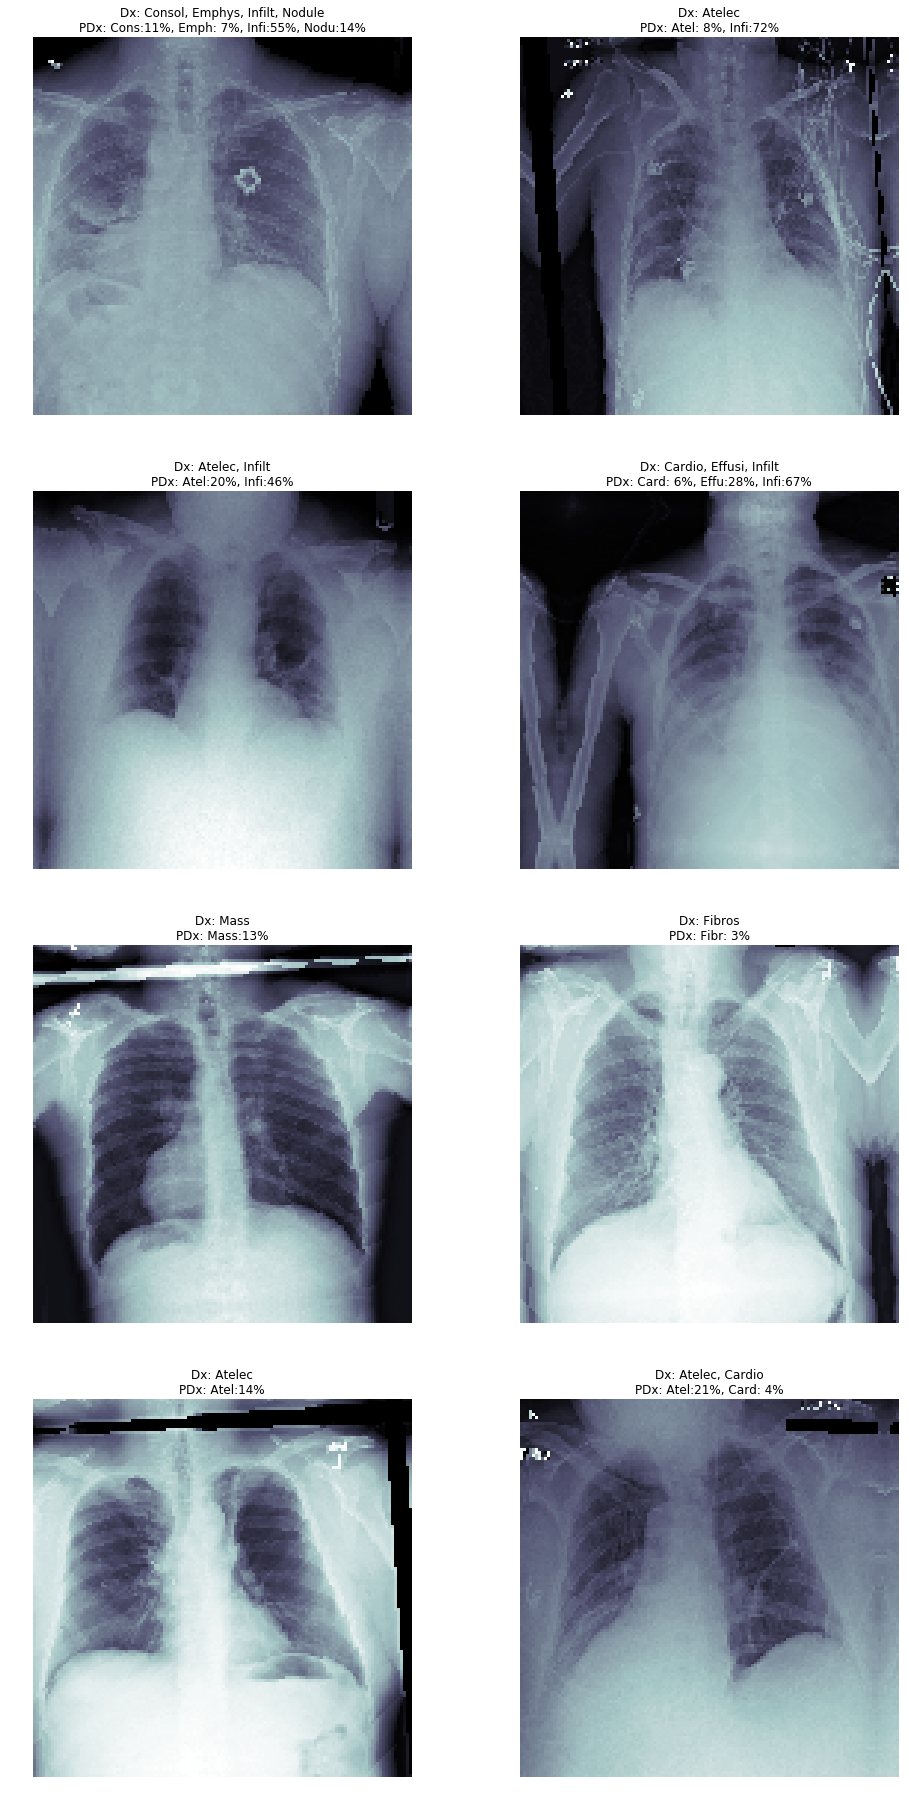

In [26]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [28]:
multi_disease_model.save('my_model.h5')



In [29]:
from IPython.display import FileLink
FileLink(r'./my_model.h5')


/kaggle/working/my_model.h5